In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score

%matplotlib inline

### Data Preparation

First, we must load the data and then transform it into a usable condition to pass into the isolation forest algorithm.

We define a list of columns that correspond with the data. Unlike some other data files, the data does not contain columns so we must define them ourselves to tell pandas what the column labels should be. Otherwise, they'll be numbered by numerical index, making it harder to interpret the data.

In [3]:
columns = ["duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes", "land", "wrong_fragment", "urgent",
        "hot", "num_failed_logins", "logged_in", "num_compromised", "root_shell", "su_attempted", "num_root", 
        "num_file_creations", "num_shells", "num_access_files", "num_outbound_cmds", "is_host_login",
        "is_guest_login", "count", "srv_count", "serror_rate", "srv_serror_rate", "rerror_rate", "srv_rerror_rate",
        "same_srv_rate", "diff_srv_rate", "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count", 
        "dst_host_same_srv_rate", "dst_host_diff_srv_rate", "dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate",
        "dst_host_serror_rate", "dst_host_srv_serror_rate", "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "label"]

df = pd.read_csv("data/kddcup.data.corrected", sep=",", names=columns, index_col=None)


This is a very large dataset. Let's only concern ourselves with http attacks

In [4]:
df.shape

(4898431, 42)

In [5]:
# Filter to only 'http' attacks
df = df[df["service"] == "http"]
df = df.drop("service", axis=1)


In [6]:
df.shape

(623091, 41)

There are many types of anomalous attacks. To make things simple, we will only detect whether a data point is normal or if it is an anomaly

In [7]:
df["label"].value_counts()

label
normal.       619046
back.           2203
neptune.        1801
portsweep.        16
ipsweep.          13
satan.             7
phf.               4
nmap.              1
Name: count, dtype: int64

In [8]:
# Label of 'normal.' becomes 0, and anything else becomes 1 and is treated as an anomaly.
df['label'] = df['label'].apply(lambda x: 0 if x=='normal.' else 1)
df['label'].value_counts()

label
0    619046
1      4045
Name: count, dtype: int64

The next step we should perform is to encode the categorical columns. However, there are many columns to search over, so let's automate this. The following cell will create a dictionary of column names to their corresponding data type. From that data type dictionary, we can iterate and find only the columns that are strings, which carry a datatype of "object" in pandas.

In [10]:
datatypes = dict(zip(df.dtypes.index, df.dtypes))

In [11]:
encoder_map = {}
for col, datatype in datatypes.items():
    if datatype == 'object':
        encoder = LabelEncoder()
        df[col] = encoder.fit_transform(df[col])
        encoder_map[col] = encoder 


Let's now check the correlation matrix with respect to the label column and filter out all the columns that are not at least weakly correlated. Remember that linear correlation can be either positive or negative, so we must filter the columns by the magnitude of their correlation.

In [12]:
# Check the variables with highest correlation with 'label'
df2 = df.copy()
label_corr = df2.corr()['label']

In [13]:
# Filter out anything that has null entry or is not weakly correlated
train_cols = label_corr[(~label_corr.isna()) & (np.abs(label_corr) > 0.2)]
train_cols = list(train_cols[:-1].index)
train_cols

['src_bytes',
 'hot',
 'num_compromised',
 'count',
 'serror_rate',
 'srv_serror_rate',
 'same_srv_rate',
 'diff_srv_rate',
 'dst_host_srv_count',
 'dst_host_same_srv_rate',
 'dst_host_diff_srv_rate',
 'dst_host_serror_rate',
 'dst_host_srv_serror_rate']

In [15]:
# Checking the correlations
label_corr[train_cols]

src_bytes                   0.732327
hot                         0.601021
num_compromised             0.611172
count                       0.353376
serror_rate                 0.556694
srv_serror_rate             0.554336
same_srv_rate              -0.620784
diff_srv_rate               0.280376
dst_host_srv_count         -0.230058
dst_host_same_srv_rate     -0.609081
dst_host_diff_srv_rate      0.258717
dst_host_serror_rate        0.607972
dst_host_srv_serror_rate    0.628432
Name: label, dtype: float64

Now that we have filtered out only the columns with a stronger correlation with label, let's split our data into train-test-val splits.

In [16]:
labels = df2['label']
# Conduct a train-test split    
x_train, x_test, y_train, y_test = train_test_split(df2[train_cols].values, labels.values, test_size = 0.15, random_state = 42)


In [17]:
# Additional split of training dataset to create validation split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [18]:
print("Shapes")
print(f"x_train:{x_train.shape}\ny_train:{y_train.shape}")
print(f"\nx_val:{x_val.shape}\ny_val:{y_val.shape}")
print(f"\nx_test:{x_test.shape}\ny_test:{y_test.shape}")

Shapes
x_train:(423701, 13)
y_train:(423701,)

x_val:(105926, 13)
y_val:(105926,)

x_test:(93464, 13)
y_test:(93464,)


In [19]:
# Let's try out isolation forest with stock parameters. It may take a bit of time to train.
isolation_forest = IsolationForest(random_state=42)

In [20]:
isolation_forest.fit(x_train)
anomaly_scores = isolation_forest.decision_function(x_train)

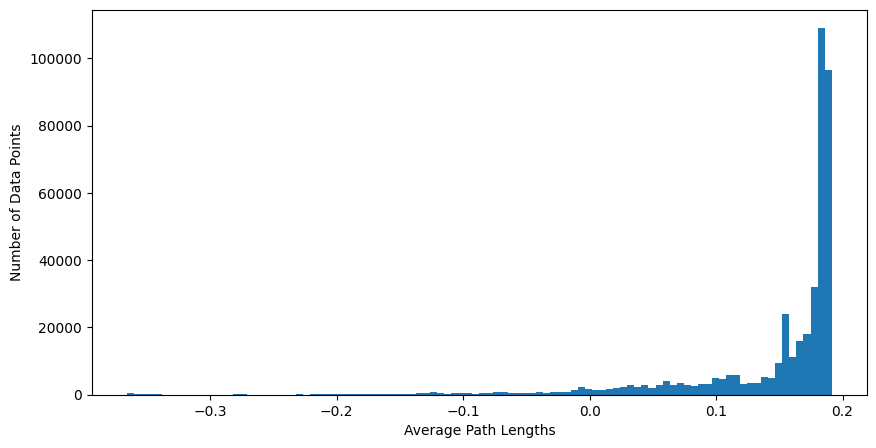

In [21]:
plt.figure(figsize=(10, 5))
plt.hist(anomaly_scores, bins=100)
plt.xlabel('Average Path Lengths')
plt.ylabel('Number of Data Points')
plt.show()

The anomaly scores are a function of the average path lengths in the forest assigned to each data point. The more negative the path length, the easier the sample was to isolate. Thus, if we look at our histogram, we can clearly see some isolated clump of outliers. Though it may be tempting to assign the threshold to be -0.3 and be done with it, that won't net you proper results.

Run the following cell and try other thresholds, you will find that the F1-Measure (the proper metric to optimize as it would ensure we adequately capture the population of anomalies and that we make accurate predictions) does not seem to be able to reach a proper score.

A score that is at least 0.9 is desirable for an F1-Measure. 

In [ ]:
threshold = -0.3
anomalies = anomaly_scores < threshold

precision = precision_score(y_train, anomalies)
recall = recall_score(y_train, anomalies)
f1 = f1_score(y_train, anomalies)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Measure: {f1}")

Precision: 0.6711345141215893
Recall: 0.5025089605734767
F1-Measure: 0.5747079319532691


So what now, is that it for the isolation forest? No, we haven't even begun the hyperparameter tuning validation process. 

The isolation forest depends heavily on its hyperparameter settings to guide how it decides to build the trees and partition the data. You must tune it for the task. With that being said, let's look at the parameters we want to tune:

- **max_samples**: how many samples to use to train each tree in the forest
- **max_features**: how many features per data point to use to train each tree in the forest
- **n_estimators**: how many trees should comprise the forest

There is also a feature, **contamination**, which tells the isolation forest what proportion of the data is contaminated by anomalies. But for this, we can calculate the proportion from our training set and pass it in directly.

### Hyperparameter Tuning with Hold-out Validation

Let's start the validation process. First, we want to tune max_samples. We do not know what range to look for, so let's go by powers of two starting from 512 and ending at 2048.

The following script is the validation framework we will be using. We will be using hold-out validation and employing our validation split that we created earlier. To be thoroughly experimentally sound, k-fold cross validation is better to use, but we just want to get a quick idea of what kind of parameters to be setting. Additionally, the validation set is a bit large  with  around ~100k records, so it should be sufficiently large to operate on directly. K-Fold is more useful when you don't have as much data to work with. 

Instead of manually setting the threshold, we are using **logistic regression** to help us predict whether a datapoint is an anomaly or not. This is a more automated method than manually experimenting with the threshold and trying out different values. However, this does insert another link in the chain that may need to be hyperparameter tuned, but we will leave it stock and as an exercise to you to see how much better you can get the performance overall.

In [28]:
# estimate proportion of anomalies. It's about 0.0065, 0.0066
(y_train==1).sum() / len(y_train)

0.006584832228387471

In [29]:
# Given an isolation_forest instance, x, and y data, train and evaluate and return results
def experiment(isolation_forest, x, y):
    isolation_forest.fit(x)
    
    anomaly_scores = isolation_forest.decision_function(x)
    
    # Using a stock Logistic Regression model to predict labels
    lr = LogisticRegression()
    lr.fit(anomaly_scores.reshape(-1, 1), y)
    
    preds = lr.predict(anomaly_scores.reshape(-1,1))
    
    pre = precision_score(y, preds)
    rec = recall_score(y, preds)
    f1 = f1_score(y, preds)
    
    return {'precision': pre, 'recall': rec, 'f1': f1}
    

#### Tuning max_samples

In [30]:
# Perform experimental search for max_samples
validation_results = {}
max_samples = [2**f for f in [8, 9, 10, 11, 12]]
for max_sample in max_samples:
    
    # We are fixing the n_estimators to 50 to be quicker. n_jobs = -1 lets us train on all cores
    isolation_forest = IsolationForest(n_estimators=50, 
                                       max_samples = max_sample, 
                                       n_jobs=-1, 
                                       contamination = 0.0066, 
                                       random_state=42)
    
    res = experiment(isolation_forest, x_val, y_val)
    validation_results[max_sample] = res
    
                       

In [31]:
# Printing out the results of the validation. The optimal setting is between 512 and 4096
[(f, validation_results[f]['f1']) for f in validation_results.keys()]

[(256, 0.5956175298804781),
 (512, 0.7805695142378559),
 (1024, 0.9556509298998569),
 (2048, 0.93361285814116),
 (4096, 0.777602523659306)]

The results already look excellent. An f1-measure of 0.95 is already well beyond what we were seeing earlier. Let's see if we can specify a finer range and discover a better hyperparameter setting.

In [32]:
# Repeat validation with a narrower range
validation_results = {}
max_samples = range(500, 2200, 200)
for max_sample in max_samples:
    
    # We are fixing the n_estimators to 50 to be quicker. n_jobs = -1 lets us train on all cores
    isolation_forest = IsolationForest(n_estimators=50, 
                                       max_samples = max_sample, 
                                       n_jobs=-1, 
                                       contamination = 0.0066, 
                                       random_state=42)
    
    res = experiment(isolation_forest, x_val, y_val)
    validation_results[max_sample] = res

In [33]:
# Printing out the results of the validation. The optimal setting is between 512 and 2048
[(f, validation_results[f]['f1']) for f in validation_results.keys()]

[(500, 0.7133984028393966),
 (700, 0.7355163727959698),
 (900, 0.7577741407528642),
 (1100, 0.9556509298998569),
 (1300, 0.9362606232294618),
 (1500, 0.956397426733381),
 (1700, 0.9323098394975575),
 (1900, 0.8104374520337683),
 (2100, 0.8592483419307295)]

The optimal ranges are between 900 and 1100, and somewhere around 1300-1700 with 1500 being the peak. Let's explore both these ranges. We will go from 950 to 1100 in increments of 10, and 1300-1700 in increments of 100.

In [34]:
# Repeat validation with a narrower range
validation_results = {}
max_samples = list(range(950, 1110, 10)) + list(range(1300, 1800, 100))
for max_sample in max_samples:
    
    # We are fixing the n_estimators to 50 to be quicker. n_jobs = -1 lets us train on all cores
    isolation_forest = IsolationForest(n_estimators=50, 
                                       max_samples = max_sample, 
                                       n_jobs=-1, 
                                       contamination = 0.0066, 
                                       random_state=42)
    
    res = experiment(isolation_forest, x_val, y_val)
    validation_results[max_sample] = res

In [35]:
# Printing out the results of the validation. The optimal setting is between 512 and 2048
[(f, validation_results[f]['f1']) for f in validation_results.keys()]

[(950, 0.9632299927901946),
 (960, 0.9618430525557955),
 (970, 0.9631768953068592),
 (980, 0.9604031677465803),
 (990, 0.9206819866567828),
 (1000, 0.9611510791366906),
 (1010, 0.9562096195262024),
 (1020, 0.9577060931899641),
 (1030, 0.9529243937232525),
 (1040, 0.9522451888809693),
 (1050, 0.8836858006042296),
 (1060, 0.9431245500359972),
 (1070, 0.9548387096774194),
 (1080, 0.9555236728837877),
 (1090, 0.9556509298998569),
 (1100, 0.9556509298998569),
 (1300, 0.9362606232294618),
 (1400, 0.9495380241648899),
 (1500, 0.956397426733381),
 (1600, 0.9468462083628633),
 (1700, 0.9323098394975575)]

We can keep going with the hyperparameter tuning or be satisfied with the values we are seeing. After some point, you will see diminishing gains, so keep that in mind in the future. From our results, it seems that the setting of 950 actually performed the best somehow, so we will use this setting as we go forward with tuning the other hyperparameters.

#### Tuning max_features

In [36]:
# Tuning max_features
validation_results = {}
max_features = range(5, 8, 1)
for max_feature in max_features:
    max_feature = max_feature / 10.0
    
    # We are fixing the n_estimators to 50 to be quicker. n_jobs = -1 lets us train on all cores
    isolation_forest = IsolationForest(n_estimators=50, 
                                       max_samples = 950,
                                       max_features = max_feature,
                                       n_jobs=-1, 
                                       contamination = 0.0066, 
                                       random_state=42)
    
    res = experiment(isolation_forest, x_val, y_val)
    validation_results[max_feature] = res

In [37]:
# Printing out the results of the validation. The optimal setting is between 512 and 2048
[(f, validation_results[f]['f1']) for f in validation_results.keys()]

[(0.5, 0.7455012853470437),
 (0.6, 0.9722627737226277),
 (0.7, 0.9693877551020408)]

Our performance is increasing more. Let's narrow the range to be between 0.55 and 0.7

In [38]:
# Tuning max_features with a narrower range
validation_results = {}
max_features = range(55, 71, 1)
for max_feature in max_features:
    max_feature = max_feature / 100.0
    
    # We are fixing the n_estimators to 50 to be quicker. n_jobs = -1 lets us train on all cores
    isolation_forest = IsolationForest(n_estimators=50, 
                                       max_samples = 950,
                                       max_features = max_feature,
                                       n_jobs=-1, 
                                       contamination = 0.0066, 
                                       random_state=42)
    
    res = experiment(isolation_forest, x_val, y_val)
    validation_results[max_feature] = res

In [39]:
# Printing out the results of the validation. The optimal setting is between 512 and 2048
[(f, validation_results[f]['f1']) for f in validation_results.keys()]

[(0.55, 0.9722627737226277),
 (0.56, 0.9722627737226277),
 (0.57, 0.9722627737226277),
 (0.58, 0.9722627737226277),
 (0.59, 0.9722627737226277),
 (0.6, 0.9722627737226277),
 (0.61, 0.9722627737226277),
 (0.62, 0.9295154185022027),
 (0.63, 0.9295154185022027),
 (0.64, 0.9295154185022027),
 (0.65, 0.9295154185022027),
 (0.66, 0.9295154185022027),
 (0.67, 0.9295154185022027),
 (0.68, 0.9295154185022027),
 (0.69, 0.9295154185022027),
 (0.7, 0.9693877551020408)]

Let's stick with 0.55 and tune our final hyperparameter, the number of estimators in the forest.

In [40]:
# Tuning max_features with a narrower range
validation_results = {}
n_estimators = range(10, 110, 10)
for n_estimator in n_estimators:
    
    # We are fixing the n_estimators to 50 to be quicker. n_jobs = -1 lets us train on all cores
    isolation_forest = IsolationForest(n_estimators=n_estimator, 
                                       max_samples = 950,
                                       max_features = 0.55,
                                       n_jobs=-1, 
                                       contamination = 0.0066, 
                                       random_state=42)
    
    res = experiment(isolation_forest, x_val, y_val)
    validation_results[n_estimator] = res

In [41]:
# Printing out the results of the validation. The optimal setting is between 512 and 2048
[(f, validation_results[f]['f1']) for f in validation_results.keys()]

[(10, 0.9799851742031134),
 (20, 0.9765395894428153),
 (30, 0.9758241758241758),
 (40, 0.9743964886613021),
 (50, 0.9722627737226277),
 (60, 0.9743964886613021),
 (70, 0.9659173313995649),
 (80, 0.9542203147353362),
 (90, 0.9568965517241379),
 (100, 0.958963282937365)]

It appears that with as little as 10 estimators in the forest, the isolation forest is able to predict anomalies quite well on the validation set. Let's keep all these hyperparameter settings, train on the training data, and evaluate on the test data and see what we get.

In [42]:
# Set our hyperparameters that we discovered during validation and train
isolation_forest = IsolationForest(n_estimators=10, 
                                   max_samples = 950,
                                   max_features = 0.55,
                                   n_jobs=-1, 
                                   contamination = 0.0066, 
                                   random_state=42)

isolation_forest.fit(x_train)
anomaly_scores = isolation_forest.decision_function(x_train)


lr = LogisticRegression()
lr.fit(anomaly_scores.reshape(-1, 1), y_train)

preds = lr.predict(anomaly_scores.reshape(-1,1))

precision = precision_score(y_train, preds)
recall = recall_score(y_train, preds)
f1 = f1_score(y_train, preds)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Measure: {f1}")

Precision: 0.9760885082084225
Recall: 0.9802867383512545
F1-Measure: 0.9781831187410587


Those are strong results, especially when compared to our stock training run. Let's see how it does on the test set now.

In [43]:
anomaly_scores = isolation_forest.decision_function(x_test)

preds = lr.predict(anomaly_scores.reshape(-1,1))

precision = precision_score(y_test, preds)
recall = recall_score(y_test, preds)
f1 = f1_score(y_test, preds)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Measure: {f1}")

Precision: 0.9773519163763066
Recall: 0.9859402460456942
F1-Measure: 0.9816272965879265


An F1-Measure of 0.979 is quite strong. Let's check the ROC-AUC score as well

In [44]:
roc_auc_score(y_test, preds)

0.9929001515496785

This is a very strong score. Though the data is imbalanced (and thus, f1-measure is better to prioritize), this does indicate strength in overall performance over normal and anomaly predictions.

Let's examine the confusion matrix using scikit-learn's visualizer:

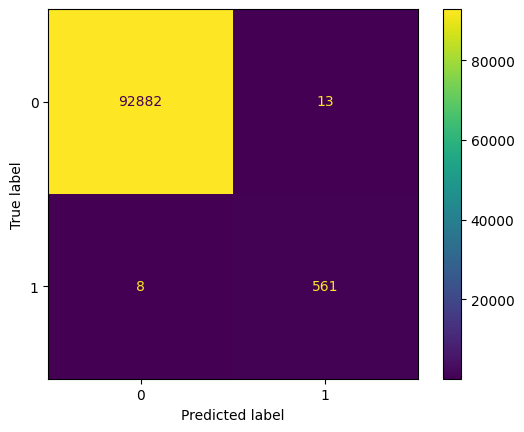

In [45]:
conf_mat = confusion_matrix(y_test, preds)
ConfusionMatrixDisplay(conf_mat).plot()
plt.show()

In [46]:
tn, fp, fn, tp = conf_mat.ravel()
print("True Negative:", tn)
print("False Negative:", fn)
print("True Positive:", tp)
print("False Positive:", fp)

True Negative: 92882
False Negative: 8
True Positive: 561
False Positive: 13


These results are quite good. Analyzing them, we see that:

- There are 8 false negatives out of 569 total anomalies. 
- There are 16 false positives out of some ~93k normal data
- The precision, recall and the f1-scores are all quite high. This is a strong anomaly detector


With that, hopefully you know how to implement isolation forest into your own datasets and apply the hyperparameter tuning process to develop a strong isolation forest model.

K-Fold cross validation might have helped us make more robust hyperparameter tuning decisions, but as far as going in the right direction, hold-out cross validation can be sufficient. 